In [1]:
# Compiled from the previous works :
# https://github.com/genzellab/HM_RAT/blob/main/SYNCHRONIZATION/synch_editedbyOzge.py
# https://github.com/genzellab/HM_RAT/blob/main/SYNCHRONIZATION/Exctract_LEDs_28_01_2023.ipynb
# https://github.com/genzellab/HM_RAT/blob/main/SYNCHRONIZATION/synchronization.py

# Author: Param Rajpura
# 28th May 2023


%matplotlib notebook
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm, tnrange
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
import pandas as pd
from scipy.signal import find_peaks,peak_prominences
from datetime import datetime , time , timedelta
import re
import functools as ft
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Extract file paths from the user defined basepath 

In [2]:
 '''
 The basepath must contain the following files:
 1. Eye video files: .mp4 formats (12 files for each eye)
 2. X,y co-ordinates of crops for LED positions : .led_crop format (1 file containing 12 xy co-ordinates)
 3. Time stamp files containing framewise clock timestamps after linear regression: .csv format (12 files)
    Note: TODO: Add the logic of meta to .csv conversion using Linear regression in this script.
 4. Time stamps recorded from LED controller referred to as DIO: .dat format (3 files for red,blue and 
 initial systime)
     a. Rat4_20201109_maze.dio_MCU_Din1.dat for initial time stamp
     b. Rat4_20201109_maze_merged.dio_MCU_Din1.dat for blue DIO
     c. Rat4_20201109_maze_merged.dio_MCU_Din2.dat for red DIO
 '''


# Reads all the mp4 files in the folder, checks for a led_crop_coordinates file and meta file
def get_video_files_with_metadata(basepath,led_xy=True,time_stamp=True):
    path = Path(basepath).resolve()
    videos_filepath_list = list(sorted(path.glob('*eye*.mp4')))
#     print(videos_filepath_list)
    
    crop_xy_dict = {}
    # Verify if led_coordinates supplied
    if led_xy:
        crop_file_list = list(sorted(path.glob('*.led_crop')))
#         print(crop_file_list)
        if crop_file_list:
            # read crops coords for each video and store
            with open(crop_file_list[0]) as f:
                crop_txt = f.readlines()
#                 print(crop_txt)
            for line in tqdm(crop_txt):
                try:
                    vid_path, x, y = line.split(',')
                    crop_xy_dict[vid_path] = (int(x), int(y))
                except ValueError:
                    print("Faulty line:", line, 'Maybe led coordinates are missing?')
                    break
        else:
            raise Exception("File containing led crop coordinates not found.")
    if time_stamp:
        # csv files no longer required since ts data extracted from meta files
#         tsdata_filepath_list = list(sorted(path.glob('*.csv')))
        meta_filepath_list = list(sorted(path.glob('*.meta')))
        
    #TODO: Verify for single file path in the list to avoid conflicting data
    dio_file_path_dict={}
    dio_file_path_dict['init'] = list(sorted(path.glob('*maze.*.dat')))
    
    dio_file_path_dict['blue'] = list(sorted(path.glob('*maze_merged*Din1.dat')))
    dio_file_path_dict['red'] = list(sorted(path.glob('*maze_merged*Din2.dat')))
    return videos_filepath_list,crop_xy_dict,meta_filepath_list,dio_file_path_dict


# Functions to extract LED signals from video data 

In [3]:
def process_ica_signals(demixed, mix_weights,time_meta):
    fps = 30.0
    eD = 0.5       # expected Duty cycle of 0.5
    ef_red = 0.5   # expected frequency of 0.5 Hz
    ef_blue = 2.5  # expected frequency of 2.5 Hz
    
    dD = np.zeros(demixed.shape[1])
    df_red = np.zeros(demixed.shape[1])
    df_blue = np.zeros(demixed.shape[1])
    
    colors = {0: 'red', 1: 'blue', None: 'gray'}
    N = -1
    N_ICA = -1  # numbers of samples to use for ICA, -1 for all
    
    # This ensures if video crop is improper or signal corrupted, that eye is ignored
    df_red_out = None
    df_blue_out = None
    
    for n in range(demixed.shape[1]):

        # Check the mixing weights if the demixed signal polarity is reversed
        # (negative weights for ROI. Assuming rest of pixel array has weight zero, mean weight tells us sign.)
        flip_ica = mix_weights[n] < 0
        if flip_ica:
            demixed[:, n] = -demixed[:, n]

        km = KMeans(n_clusters=2, random_state=0).fit(demixed[:, n].reshape(-1, 1))
        y_km = km.predict(demixed[:, n].reshape(-1, 1))

        # check polarity, if necessary flip to match pulse polarity
        # print(f'Centers: {float(km.cluster_centers_[0]*1000):.2f}, {float(km.cluster_centers_[1]*1000):.2f}')
        centers = km.cluster_centers_.ravel()

        flip_kmeans = centers[0] > centers[1]
        flip = flip_ica ^ flip_kmeans
        # print(f'Polarity FLIP: {flip} (ICA {flip_ica}, kmeans {flip_kmeans})')
        if flip_kmeans:
            # print('Flipping!')
            y_km = np.abs(y_km-1)

        duty_cycle = y_km.sum()/len(y_km)
        freq = (np.diff(y_km)>0).sum()/len(y_km) * fps
        dD[n] = abs(eD-duty_cycle)
        df_red[n] = abs(ef_red - freq)
        df_blue[n] = abs(ef_blue - freq)

        # Attempt to identify the ICA signal as a color LED
        good_DC = dD[n] < 0.2 * eD
        good_freq = np.array([df_red[n] < ef_red * 0.1, df_blue[n] < ef_blue * 0.1])
        is_signal = good_DC and good_freq.sum()
        signal_color = good_freq.argmax() if is_signal else None
        print(f"ICA signal number: {n}, DutyCycle:{duty_cycle}, Freq:{freq}")
        sig_col = colors[signal_color]
        sig_name = 'None' if signal_color is None else colors[signal_color]
        
        if sig_col=='red':
            a = y_km[:N]
            df_red_out = pd.DataFrame({'key' : [], "LED_Intensity" : []})
            # "Red_LED_Intensity_%s" %(eye)
            df_red_out['key'] = time_meta[0:(len(demixed[:N, n]-1))]
            df_red_out["LED_Intensity"] = demixed[:N, n]
        elif sig_col=='blue':
            a = y_km[:N]
            df_blue_out = pd.DataFrame({'key' : [], "LED_Intensity" : []})
            # "Red_LED_Intensity_%s" %(eye)
            df_blue_out['key'] = time_meta[0:(len(demixed[:N, n]-1))]
            df_blue_out["LED_Intensity"] = demixed[:N, n]
    return df_red_out,df_blue_out


# The offset is subtracted to make sure the drift is 0 at the start and at the end between the timestamps.
def pred_cpu_ts_from_gpu_ts(gpu, cpu):
    # Fit a linear regression model between GPU and CPU timestamps
    reg = LinearRegression().fit(gpu.reshape(-1, 1), cpu)
    # Use the model to predict CPU timestamps
    reg_ts = reg.predict(gpu.reshape(-1, 1))
    # Calculate the mean difference between the predicted and actual CPU timestamps for the first 1000 samples
    offset = (reg_ts - cpu)[:1000].mean()
    # Adjust the predicted CPU timestamps by the offset
    Corr_ts = reg_ts - offset
    print(f"gpu ts:{gpu[0]}, cpu_ts: {cpu[0]}, reg_ts: {reg_ts[0]}, offset: {offset}, corrected ts:{Corr_ts[0]}")
    return Corr_ts


# # Function without subtracting offset
# # FOr visualisation check helper function vis_gpu_cpu_ts
# def pred_cpu_ts_from_gpu_ts(gpu_train, cpu_train, gpu_test,cpu_test_eval=None):
#     reg = LinearRegression().fit(gpu_train.reshape(-1, 1), cpu_train)
#     print("Regression coefficients of GPU2CPU linear model:",reg.coef_)
#     pred_cpu = reg.predict(gpu_test.reshape(-1, 1))
#     pred_score = None
#     # If true dio values are passed in inputs, compute R-squared scores for performance
#     if cpu_test_eval is not None:
#         pred_score = reg.score(gpu_test.reshape(-1, 1),cpu_test_eval)
#     return pred_cpu,pred_score

def vis_gpu_cpu_ts(path='/home/genzel/param/sync_inp_files'):
    # Verify the gpu vs cpu timestamp relationship
    path = Path(path).resolve()
    meta_filepath_list = list(sorted(path.glob('*.meta')))
    for filepath in meta_filepath_list:
        ts_data = np.genfromtxt(filepath, delimiter=',', names=True)
    #     print(ts_data['callback_gpu_ts'], ts_data['callback_clock_ts'])
    
        corr_cpu_ts = pred_cpu_ts_from_gpu_ts(ts_data['callback_gpu_ts'], ts_data['callback_clock_ts'])
        df = pd.DataFrame()
        df['extracted_seconds_timestamp'] = pd.to_datetime(corr_cpu_ts,unit='s',utc=True)
        df['extracted_seconds_timestamp'] = df['extracted_seconds_timestamp'].dt.tz_convert('CET').dt.tz_localize(
            None)
    #     print("R squared score of the GPU2CPU linear model: ",pred_score)
        error = ts_data['callback_clock_ts'] - corr_cpu_ts
        plt.figure()
        plt.plot(error)
        plt.title("Error in original and predicted CPU timestamp")
        plt.show()
        plt.figure()
        plt.plot(ts_data['callback_gpu_ts']- ts_data['callback_clock_ts'])
        plt.show()

In [4]:
def process_video_with_metadata(file_path,xy_coord,meta_filepath,process_frame_count):
    cap = cv2.VideoCapture(str(file_path))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_process = process_frame_count if process_frame_count is not None else frame_count
    
    # read time stamps from the meta file : alternative but uncorrected
    # Getting the data from the metadata files
    ts_data = np.genfromtxt(meta_filepath, delimiter=',', names=True)

    # Correcting the timestamps from meta file using linear regression
    corr_cpu_ts = pred_cpu_ts_from_gpu_ts(ts_data['callback_gpu_ts'], ts_data['callback_clock_ts'])
    df = pd.DataFrame()
    df['extracted_seconds_timestamp'] = pd.to_datetime(corr_cpu_ts,unit='s',utc=True)
    df['extracted_seconds_timestamp'] = df['extracted_seconds_timestamp'].dt.tz_convert('CET').dt.tz_localize(
        None)

    # extract time stamps from the csv files based on sync_edited: as they are corrected timestamps
    # Not using this since meta files can be used instead of csv and csv vs meta values didnt match 
    # with linear regression
#     df = pd.read_csv(str(ts_file_path), sep=',',parse_dates=['Timestamps_M'])#dtype=str)
#     df['extracted_seconds_timestamp'] = pd.to_datetime(df['Timestamps_M'], unit='s',utc=True)
#     df['extracted_seconds_timestamp'] = df['extracted_seconds_timestamp'].dt.tz_convert('CET').dt.tz_localize(None)
#     print(df['extracted_seconds_timestamp']) # time_meta 
#     print(df['extracted_seconds_timestamp'][0].value/ 10**9) # time_meta 
    
    
    
#     df = pd.read_csv(str(ts_file_path), sep=',',parse_dates=['callback_clock_ts'])#dtype=str)
#     df['extracted_seconds_timestamp'] = pd.to_datetime(df['callback_clock_ts'], unit='s')
    
    if(frame_count != len(df['extracted_seconds_timestamp'])):
        print("Frame counts do not match!!!")
        print(f"Frame count from video({frame_count})")
        print(f"Frame count from metadata({len(df['extracted_seconds_timestamp'])})")
    
              
    rgb_frames = np.empty((frames_to_process,16,16,3))
#     while(cap.isOpened()):
    for i in range(frames_to_process):
        ret, frame = cap.read()
        if frame is None:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Start coordinate, here (5, 5)
        # represents the top left corner of rectangle
        start_point = (xy_coord[0]-8, xy_coord[1]-8)


        frame = frame[start_point[1]:start_point[1]+16,start_point[0]:start_point[0]+16]
#         rgb_frames = np.append(rgb_frames,frame.reshape(-1, 16, 16, 3), axis=0)
        rgb_frames[i,:,:,:] = frame
#         cv2.imshow('ImageWindow', frame)
#         cv2.waitKey(1)
        if i % 1000 == 0:
            print(i,datetime.now(),end='\r')
#     print(rgb_frames)
#     cv2.destroyAllWindows()
#     cv2.waitKey(1)
    cap.release()
    # number of components to extract from image crops: blue, red and noise
    nc = 3 
    ica = FastICA(n_components=nc, random_state=0)
    # reshape rgb_frames to a 2Darray
    X = rgb_frames.reshape(rgb_frames.shape[0], -1).astype(float) 
#     print(X.shape)
    # extraction of the independent signals 
    demixed = ica.fit_transform(X)
    mix_weights = ica.mixing_.mean(axis=0)
    
    red_ica_df,blue_ica_df = process_ica_signals(demixed,mix_weights,df['extracted_seconds_timestamp'])
    
    return red_ica_df,blue_ica_df


# Code to visualise the red_ica_df
#     fig, ax = plt.subplots(1, figsize=(40, 8)) #sharex="col", sharey=True )
#     ax.plot(red_ica_df['key'], red_ica_df['Red_LED_Intensity'], c='r')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Sum of ICAs (Red LED Intensities) of All Eyes')
#     # ax.set_xlim([df_final['key'][0], df_final['key'][width]])
#     plt.tight_layout()


In [5]:
def extract_com_from_merged_ica(agg_ica):
    # threhold
    agg_ica_thresh = agg_ica.Total_Intensity > 0
    
    # Save binarized and summed red ICA and correspnding timstamps
    agg_ica_out = pd.DataFrame({'Time_in_seconds' : [], 'ICA' : []})
    agg_ica_out.Time_in_seconds = agg_ica['key']
    agg_ica_out.ICA = agg_ica_thresh.astype(int)
    
#     time_ica = ica_red['Time_in_seconds']
#     ica_int = ica_red['ICA']
    sig_med = np.array(np.diff(agg_ica_out.ICA))
    sig_med = np.append(0, sig_med) # why add this 0 ? depends on any condition
    rising_edge = np.asarray(np.where(sig_med==1)).flatten()
    falling_edge = np.asarray(np.where(sig_med==-1)).flatten()
    com_ica = pd.DataFrame({'Center_of_mass' : []})  
    if agg_ica_out.Time_in_seconds[rising_edge[0]] < agg_ica_out.Time_in_seconds[falling_edge[0]]:  
        for i in range(min(len(rising_edge), len(falling_edge))):
            com_ica.at[i, 'Center_of_mass'] = agg_ica_out.Time_in_seconds[rising_edge[i]]
            +(agg_ica_out.Time_in_seconds[falling_edge[i]]
              -agg_ica_out.Time_in_seconds[rising_edge[i]])/2
    else:
        for i in range(min(len(rising_edge), len(falling_edge))-1):
            com_ica.at[i, 'Center_of_mass'] = agg_ica_out.Time_in_seconds[rising_edge[i]]
            +(agg_ica_out.Time_in_seconds[falling_edge[i+1]]
              -agg_ica_out.Time_in_seconds[rising_edge[i]])/2
    return com_ica


def merge_ica_and_extract_com(red_ica_list,blue_ica_list):
    # merge all eye data when running for all eyes
    it = iter(range(len(red_ica_list))) 
    red_ica_total = ft.reduce(lambda left, right: pd.merge(left, right, on='key', how='outer', 
                                                      suffixes=(None,"_"+str(next(it)))), 
                              red_ica_list)
    red_ica_total = red_ica_total.sort_values('key')
#     print("Before interpolation:",red_ica_total.isnull().sum())
    for column in red_ica_total.columns:
        if column == 'key':
            continue
        else:
            red_ica_total[column] = red_ica_total[column].interpolate()
#     red_ica_total.filter(like='LED_Intensity').interpolate(inplace=True)
    #red_ica_total.interpolate(inplace=True)# red_ica_total.fillna(0) # red_ica_total.filter(like='LED_Intensity').interpolate(inplace=True) #
#     print("After interpolation:",red_ica_total.isnull().sum())
    
    it = iter(range(len(blue_ica_list)))                          
    blue_ica_total = ft.reduce(lambda left, right: pd.merge(left, right, on='key', how='outer', 
                                                      suffixes=(None,"_"+str(next(it)))),
                               blue_ica_list)  
    blue_ica_total = blue_ica_total.sort_values('key')
#     print("Before interpolation:",blue_ica_total.isnull().sum())
    for column in blue_ica_total.columns:
        if column == 'key':
            continue
        else:
            blue_ica_total[column] = blue_ica_total[column].interpolate()
#     print("After interpolation:",blue_ica_total.isnull().sum())
    
    red_ica_total['Total_Intensity'] = red_ica_total.filter(like='LED_Intensity').sum(1)
    blue_ica_total['Total_Intensity'] = blue_ica_total.filter(like='LED_Intensity').sum(1)
    
    red_ica_total = red_ica_total[['key', 'Total_Intensity']]
    red_ica_total = red_ica_total.reset_index(drop=True)
    blue_ica_total = blue_ica_total[['key', 'Total_Intensity']]
    blue_ica_total = blue_ica_total.reset_index(drop=True)
#     print(red_ica_total)
#     print(blue_ica_total)
#     fig, ax = plt.subplots(1, figsize=(40, 8))
#     ax.plot(red_ica_total['key'], red_ica_total['Total_Intensity'], c='r')
#     ax.plot(blue_ica_total['key'], blue_ica_total['Total_Intensity'], c='b')


    # get centre of mass for both aggregated signals
    red_ica_com = extract_com_from_merged_ica(red_ica_total)
    blue_ica_com = extract_com_from_merged_ica(blue_ica_total)
    
    return red_ica_com, blue_ica_com, red_ica_total, blue_ica_total

# Functions to extract DIO signals and centre of mass from metadata files 

In [6]:
#Extract DIOS

def readTrodesExtractedDataFile(filename):
    with open(filename, 'rb') as f:
        # Check if first line is start of settings block
        if f.readline().decode('ascii').strip() != '<Start settings>':
            raise Exception("Settings format not supported")
        fields = True
        fieldsText = {}
        for line in f:
            # Read through block of settings
            if(fields):
                line = line.decode('ascii').strip()
                # filling in fields dict
                if line != '<End settings>':
                    vals = line.split(': ')
                    fieldsText.update({vals[0].lower(): vals[1]})
                # End of settings block, signal end of fields
                else:
                    fields = False
                    dt = parseFields(fieldsText['fields'])
                    fieldsText['data'] = np.zeros([1], dtype = dt)
                    break
        # Reads rest of file at once, using dtype format generated by parseFields()
        dt = parseFields(fieldsText['fields'])
        data = np.fromfile(f, dt)
        fieldsText.update({'data': data})
        return fieldsText
# Parses last fields parameter (<time uint32><...>) as a single string
# Assumes it is formatted as <name number * type> or <name type>
# Returns: np.dtype
def parseFields(fieldstr):
    # Returns np.dtype from field string
    sep = re.split('\s', re.sub(r"\>\<|\>|\<", ' ', fieldstr).strip())
    # print(sep)
    typearr = []
    # Every two elmts is fieldname followed by datatype
    for i in range(0,sep.__len__(), 2):
        fieldname = sep[i]
        repeats = 1
        ftype = 'uint32'
        # Finds if a <num>* is included in datatype
        if sep[i+1].__contains__('*'):
            temptypes = re.split('\*', sep[i+1])
            # Results in the correct assignment, whether str is num*dtype or dtype*num
            ftype = temptypes[temptypes[0].isdigit()]
            repeats = int(temptypes[temptypes[1].isdigit()])
        else:
            ftype = sep[i+1]
        try:
            fieldtype = getattr(np, ftype)
        except AttributeError:
            print(ftype + " is not a valid field type.\n")
            exit(1)
        else:
            typearr.append((str(fieldname), fieldtype, repeats))
    return np.dtype(typearr)


def extract_dio_com(dio_file_path_dict):
    sys_time_dict = readTrodesExtractedDataFile(dio_file_path_dict['init'][0])
    sys_time = int(sys_time_dict['system_time_at_creation'])/1000
    timestamp_at_creation = int(sys_time_dict['timestamp_at_creation'])#/1000
    sys_time_dt = datetime.utcfromtimestamp(sys_time)#pd.to_datetime(sys_time, unit='s',utc=True)#
#     print(pd.to_datetime(sys_time, unit='s'),sys_time_dt,datetime.utcfromtimestamp(timestamp_at_creation/1000))
    print(sys_time,sys_time_dt)
    red_dict_dio = readTrodesExtractedDataFile(dio_file_path_dict['red'][0])
    red_DIO = red_dict_dio['data']
    
    red_DIO_ts = [((sys_time_dt + timedelta(seconds = (i[0]-timestamp_at_creation)/ 30000)).timestamp(),
                   i[1]) for i in red_DIO]
#     print(red_DIO)
    red_DIO_df  = pd.DataFrame({"Time_Stamp_(DIO)" : [datetime.fromtimestamp(i[0]) for i in red_DIO_ts], 
                                "Time_in_seconds_(DIO)" : [str(i[0]) for i in red_DIO_ts], 
                                "State": [i[1] for i in red_DIO_ts]} )
#     print(red_DIO_ts)
#     print(red_DIO_df)
    
    blue_dict_dio = readTrodesExtractedDataFile(dio_file_path_dict['blue'][0])
    blue_DIO = blue_dict_dio['data']
    blue_DIO_ts = [((sys_time_dt + timedelta(seconds = (i[0]-timestamp_at_creation)/ 30000)).timestamp() , 
                    i[1]) for i in blue_DIO]
    blue_DIO_df  = pd.DataFrame({"Time_Stamp_(DIO)" : [datetime.fromtimestamp(i[0]) for i in blue_DIO_ts], 
                                 "Time_in_seconds_(DIO)" : [str(i[0]) for i in blue_DIO_ts], 
                                 "State": [i[1] for i in blue_DIO_ts]} )
    
#     # Visualise DIO raw signals
#     fig, ax = plt.subplots()
#     h1 = ax.stem(red_DIO_df["Time_Stamp_(DIO)"], red_DIO_df["State"],'red',markerfmt='ro') #markerfmt=' '
#     h2 = ax.stem(blue_DIO_df["Time_Stamp_(DIO)"], blue_DIO_df["State"],'blue',markerfmt='bo') #markerfmt=' '
    
#     proxies = [h1,h2]
#     legend_names = ['Red_DIO','Blue_DIO']
#     plt.legend(proxies, legend_names, loc='best', numpoints=1)
#     for h in proxies:
#         h.set_visible(False)
#     plt.show()
    
    
    com_dio_red = pd.DataFrame({'Center_of_mass' : []})
    if red_DIO_df["State"][0]==1:
        for i in range(2, len(red_DIO_df["State"]), 2):
            com_dio_red.at[(i-2)/2, 'Center_of_mass'] = red_DIO_df["Time_Stamp_(DIO)"][i-2]
            +(red_DIO_df["Time_Stamp_(DIO)"][i]-red_DIO_df["Time_Stamp_(DIO)"][i-2])/2
    else:
        for i in range(3, len(red_DIO_df["State"]), 2):
            com_dio_red.at[(((i-1)/2)-1), 'Center_of_mass'] = red_DIO_df["Time_Stamp_(DIO)"][i-2]
            +(red_DIO_df["Time_Stamp_(DIO)"][i]-red_DIO_df["Time_Stamp_(DIO)"][i-2])/2
            
    
    com_dio_blue = pd.DataFrame({'Center_of_mass' : []})
    if blue_DIO_df["State"][0]==1:
        for i in range(2, len(blue_DIO_df["State"]), 2):
            com_dio_blue.at[(i-2)/2, 'Center_of_mass'] = blue_DIO_df["Time_Stamp_(DIO)"][i-2]
            +(blue_DIO_df["Time_Stamp_(DIO)"][i]-blue_DIO_df["Time_Stamp_(DIO)"][i-2])/2
    else:
        for i in range(3, len(blue_DIO_df["State"]), 2):
            com_dio_blue.at[(((i-1)/2)-1), 'Center_of_mass'] = blue_DIO_df["Time_Stamp_(DIO)"][i-2]
            +(blue_DIO_df["Time_Stamp_(DIO)"][i]-blue_DIO_df["Time_Stamp_(DIO)"][i-2])/2
    return com_dio_red,com_dio_blue

# Function to visualise the ICA and DIO COMs, verify the initial shift and constant delay between signals

In [7]:
def visualise_ica_dio_coms(dio_com_red,ica_com_red,dio_com_blue,ica_com_blue):    
    dio_com_red["Amp"] = 0.6
    ica_com_red["Amp"] = 0.6
    dio_com_blue["Amp"] = 0.5
    ica_com_blue["Amp"] = 0.5
    # dio_com["Center_of_mass"] = pd.to_datetime(dio_com["Center_of_mass"])

    # ax1 = dio_com_red.plot(kind='scatter', x="Center_of_mass", y='Amp', color='r') 
    # ax2 = ica_com_red.plot(kind='scatter', x="Center_of_mass", y='Amp', color='orange',ax=ax1)
    # ax3 = ica_com_blue.plot(kind='scatter', x="Center_of_mass", y='Amp', color='b',ax=ax1)
    # ax3 = dio_com_blue.plot(kind='scatter', x="Center_of_mass", y='Amp', color='c',ax=ax1)


    fig, ax = plt.subplots()
    h1 = ax.stem(dio_com_red["Center_of_mass"], dio_com_red["Amp"],'red',markerfmt='ro') #markerfmt=' '
    h2 = ax.stem(ica_com_red["Center_of_mass"], ica_com_red["Amp"],'orange',markerfmt='yo')

    h3 = ax.stem(dio_com_blue["Center_of_mass"], dio_com_blue["Amp"],'blue',markerfmt='bo')
    h4 = ax.stem(ica_com_blue["Center_of_mass"], ica_com_blue["Amp"],'cyan',markerfmt='co')
    
    proxies = [h1,h2,h3,h4]
    legend_names = ['Red_DIO','Red_ICA','Blue_DIO','Blue_ICA']
    plt.legend(proxies, legend_names, loc='best', numpoints=1)
#     for h in proxies:
#         h.set_visible(False)
    plt.show()


In [8]:
'''Assuming that this model will be specific to each set of eye videos
We train the model everytime and predict the timestamps
The predicted timestamps will have some error so ultimately a closest dio time stamp to the 
predicted dio time stamp shall be chosen for analysis.'''

# Old one without offset
# def pred_dio_ts_from_ica_ts(ica_train, dio_train, ica_test,dio_test_eval=None):
#     reg = LinearRegression().fit(ica_train.reshape(-1, 1), dio_train)
#     print("Regression coefficients of ICA2DIO linear model:",reg.coef_)
#     pred_dio = reg.predict(ica_test.reshape(-1, 1))
#     pred_score = None
#     # If true dio values are passed in inputs, compute R-squared scores for performance
#     if dio_test_eval is not None:
#         pred_score = reg.score(ica_test.reshape(-1, 1),dio_test_eval)
#     return pred_dio,pred_score




# New one with offset
def pred_dio_ts_from_ica_ts_and_verify(ica_train, dio_train,test_cpu_blue,test_cpu_red,frame_wise_ts,
                                       vis_on=False):
    reg = LinearRegression().fit(ica_train.reshape(-1, 1), dio_train)
#     print("Regression coefficients of ICA2DIO linear model:",reg.coef_)
    pred_dio_blue = reg.predict(test_cpu_blue.reshape(-1, 1))
    pred_dio_red = reg.predict(test_cpu_red.reshape(-1, 1))
    pred_frame_wise_ts = reg.predict(frame_wise_ts.reshape(-1, 1))
    offset_red = pred_dio_red[0] - test_cpu_red[0]
    offset_blue = pred_dio_blue[0] - test_cpu_blue[0]
    assert offset_red == offset_blue, f"Offset in red({offset_red}) and blue ({offset_blue})signal is not same"
    print("Offset for final correction(s) is: ",offset_red)
    pred_dio_blue = pred_dio_blue - offset_blue
    pred_dio_red = pred_dio_red - offset_red
    pred_frame_wise_ts = pred_frame_wise_ts - offset_red
    # Try dio test instead of testcpu
    if vis_on:
        plt.figure()
        plt.plot(pred_dio_blue)
        plt.title("Predicted ts vs Frame number")
        plt.show()
        
        plt.figure()
        plt.plot(pred_dio_blue - test_cpu_blue)
        plt.title("Predicted ts-cpu vs Frame number")
        plt.show()
        
        val_dio = reg.predict(ica_train.reshape(-1, 1))
        plt.figure()
        plt.plot(val_dio - dio_train)
        plt.title("pred dio on train - dio ground truth vs Frame number")
        plt.show()
        
        plt.figure()
        plt.plot(pred_frame_wise_ts - frame_wise_ts)
        plt.title("pred framewise ts - cpu avg framewise ts vs Frame number")
        plt.show()
    return pred_dio_blue,pred_dio_red,pred_frame_wise_ts


# Finding first overlap needs to be after the first DIO signals in red/blue
def trim_ts_before_first_overlap(ica_ts_red,dio_ts_red,ica_ts_blue,dio_ts_blue):
    start_point_ica= 0
    # trimmed dio is the first and last signal removed
    trimmed_dio_red = dio_ts_red.values[1:-2]
    print(f"trimmed dio len: {trimmed_dio_red.shape}, before trim: {dio_ts_red.shape} ")
    trimmed_ica_red_front = ica_ts_red[(ica_ts_red > dio_ts_red.values[0])].to_numpy()
    print(f"trimmed ica front len: {trimmed_ica_red_front.shape}, before trim: {ica_ts_red.shape} ")
    trimmed_ica_red = trimmed_ica_red_front[start_point_ica:len(trimmed_dio_red)+start_point_ica]
    print(f"trimmed ica len: {trimmed_ica_red.shape}, before trim: {ica_ts_red.shape} ")
    # trimmed ica is the ma
    
    # trimmed ica signals to start after the timestamp when DIO was initialised
    # trimmed ica signals to end before the last DIO since that might be corrupted when switched off.
#     trimmed_ica = ica_ts[(ica_ts > dio_ts.values[0]) & (ica_ts < dio_ts.values[-2])].to_numpy()
    
    # After the signal is trimmed, need to check if there are any outliers or abnormal shifts
#     trimmed_dio = dio_ts.to_numpy()[1:len(trimmed_ica)+1]
    diff = trimmed_dio_red - trimmed_ica_red
    print("Red: Trimmed dio - Trimmed ICA difference is: ",diff)
    plt.figure()
    plt.plot(diff)
    plt.title("diff between RED : trimmed dio and trimmed ica vs Frame number")
    plt.show()
    
    
    # trimmed dio is the first and last signal removed
    trimmed_dio_blue = dio_ts_blue[(dio_ts_blue > dio_ts_red.values[0]) & 
                                   (dio_ts_blue < dio_ts_red.values[-1])].to_numpy()
    print(f"trimmed dio len: {trimmed_dio_blue.shape}, before trim: {dio_ts_blue.shape} ")
    trimmed_ica_blue_front = ica_ts_blue[(ica_ts_blue > dio_ts_red.values[0])].to_numpy()
    print(f"trimmed ica front len: {trimmed_ica_blue_front.shape}, before trim: {ica_ts_blue.shape} ")
    trimmed_ica_blue = trimmed_ica_blue_front[5*start_point_ica:len(trimmed_dio_blue)+5*start_point_ica]
    print(f"trimmed ica len: {trimmed_ica_blue.shape}, before trim: {ica_ts_blue.shape} ")
    # trimmed ica is the ma
    
    # trimmed ica signals to start after the timestamp when DIO was initialised
    # trimmed ica signals to end before the last DIO since that might be corrupted when switched off.
#     trimmed_ica = ica_ts[(ica_ts > dio_ts.values[0]) & (ica_ts < dio_ts.values[-2])].to_numpy()
    
    # After the signal is trimmed, need to check if there are any outliers or abnormal shifts
#     trimmed_dio = dio_ts.to_numpy()[1:len(trimmed_ica)+1]
    diff = trimmed_dio_blue - trimmed_ica_blue
    print("Trimmed dio - Trimmed ICA difference is: ",diff)
    plt.figure()
    plt.plot(diff)
    plt.title("diff between trimmed dio and trimmed ica vs Frame number")
    plt.show()
    
    return trimmed_ica_red,trimmed_dio_red,trimmed_ica_blue,trimmed_dio_blue

# Main code using previously defined functions to generate ICA vs DIO visualisation and sync

In [9]:
inp_path = '/home/genzel/param/sync_inp_files'
out_path = '/home/genzel/param/outpath/'
# Get file list paths and the metadata paths related to it : dio timestamps, xy co-ords, ???
vfl,xy_dict,meta_file_list,dio_file_path_dict = get_video_files_with_metadata(inp_path)



#TODO: Verify the list from user
# print(vfl,xy_dict,tsfl,dio_file_path_dict)
print(meta_file_list)



  0%|          | 0/12 [00:00<?, ?it/s]

[PosixPath('/home/genzel/param/sync_inp_files/eye01_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye02_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye03_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye04_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye05_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye07_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye08_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye09_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye10_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye11_2020-11-09_12-34-18.meta'), PosixPath('/home/genzel/param/sync_inp_files/eye12_2020-11-09_12-34-18.meta')]


In [10]:
# loop over each video file to get the df
red_ica_list = []
blue_ica_list = []
process_frame_count = None
for itr,video_file_path in enumerate(vfl):
    print("Processing for eye:",itr)
    print("Filepath:",video_file_path)
    print("XY coordinates for crop:",xy_dict[str(video_file_path)])
    
    red_ica_out,blue_ica_out = process_video_with_metadata(video_file_path,xy_dict[str(video_file_path)],
                                                           meta_file_list[itr],process_frame_count)
    if (red_ica_out is not None) and (blue_ica_out is not None): 
        red_ica_list.append(red_ica_out)
        blue_ica_list.append(blue_ica_out)
        print("=================")
    else:
        print("CORRUPTED SIGNAL/VIDEO CROP....IGNORING:",str(video_file_path))




Processing for eye: 0
Filepath: /home/genzel/param/sync_inp_files/eye01_2020-11-09_12-34-18.mp4
XY coordinates for crop: (566, 731)
gpu ts:699142308496.0, cpu_ts: 1604918058.460756, reg_ts: 1604918058.4617968, offset: 0.0009696433544158935, corrected ts:1604918058.460827


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.0009976720984369804, Freq:0.0056278938886188635
ICA signal number: 1, DutyCycle:0.5065786668713174, Freq:0.5024174362385204
ICA signal number: 2, DutyCycle:0.5535118910576177, Freq:2.4847151518252284
Processing for eye: 1
Filepath: /home/genzel/param/sync_inp_files/eye02_2020-11-09_12-34-18.mp4
XY coordinates for crop: (193, 731)
gpu ts:699145901820.0, cpu_ts: 1604918058.461328, reg_ts: 1604918058.4623597, offset: 0.0009796512126922607, corrected ts:1604918058.46138


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.8134950073759518, Freq:2.7745516870890996
ICA signal number: 1, DutyCycle:0.541147578726561, Freq:2.4834360850323605
ICA signal number: 2, DutyCycle:0.5056406845565475, Freq:0.4993476759356374
Processing for eye: 2
Filepath: /home/genzel/param/sync_inp_files/eye03_2020-11-09_12-34-18.mp4
XY coordinates for crop: (481, 731)
gpu ts:699141161179.0, cpu_ts: 1604918058.478118, reg_ts: 1604918058.4791903, offset: 0.0010097856521606445, corrected ts:1604918058.4781806


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.5379374445732997, Freq:2.4834572617504604
ICA signal number: 1, DutyCycle:0.5734020055938331, Freq:3.0833447029128864
ICA signal number: 2, DutyCycle:0.504485299133638, Freq:0.49884030288559933
Processing for eye: 3
Filepath: /home/genzel/param/sync_inp_files/eye04_2020-11-09_12-34-18.mp4
XY coordinates for crop: (117, 724)
gpu ts:699148008480.0, cpu_ts: 1604918058.471754, reg_ts: 1604918058.4728491, offset: 0.0010380709171295165, corrected ts:1604918058.471811


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.6952069103715263, Freq:0.4034176664705431
ICA signal number: 1, DutyCycle:0.5038499910465325, Freq:0.4988360492184902
ICA signal number: 2, DutyCycle:0.5382057251029648, Freq:2.4834360850323605
Processing for eye: 4
Filepath: /home/genzel/param/sync_inp_files/eye05_2020-11-09_12-34-18.mp4
XY coordinates for crop: (383, 623)
gpu ts:699145245986.0, cpu_ts: 1604918058.468963, reg_ts: 1604918058.4700136, offset: 0.0009748663902282715, corrected ts:1604918058.4690387


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.3304057165271075, Freq:0.009465013557992393
ICA signal number: 1, DutyCycle:0.5441530091921483, Freq:2.48341490867541
ICA signal number: 2, DutyCycle:0.5044852226409946, Freq:0.5006224738646248
Processing for eye: 5
Filepath: /home/genzel/param/sync_inp_files/eye07_2020-11-09_12-34-18.mp4
XY coordinates for crop: (23, 628)
gpu ts:699146504320.0, cpu_ts: 1604918058.465673, reg_ts: 1604918058.4667776, offset: 0.0010343477725982665, corrected ts:1604918058.4657433


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.8867523918345073, Freq:1.576308474171598
ICA signal number: 1, DutyCycle:0.5083820795743302, Freq:0.4988317956239235
ICA signal number: 2, DutyCycle:0.5668860958098129, Freq:2.48341490867541
Processing for eye: 6
Filepath: /home/genzel/param/sync_inp_files/eye08_2020-11-09_12-34-18.mp4
XY coordinates for crop: (392, 632)
gpu ts:699147633606.0, cpu_ts: 1604918058.458613, reg_ts: 1604918058.4597268, offset: 0.0010247092247009277, corrected ts:1604918058.458702


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.9301032633257442, Freq:2.0969021002276738
ICA signal number: 1, DutyCycle:0.5054701423174985, Freq:0.4988360492184902
ICA signal number: 2, DutyCycle:0.5528297221014215, Freq:2.4834360850323605
Processing for eye: 7
Filepath: /home/genzel/param/sync_inp_files/eye09_2020-11-09_12-34-18.mp4
XY coordinates for crop: (115, 649)
gpu ts:699147066237.0, cpu_ts: 1604918058.456079, reg_ts: 1604918058.4571333, offset: 0.0010104844570159913, corrected ts:1604918058.4561229


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.5464770236968441, Freq:2.4834360850323605
ICA signal number: 1, DutyCycle:0.5053166543023543, Freq:0.4988360492184902
ICA signal number: 2, DutyCycle:0.4859856915061438, Freq:2.9758768002865112
Processing for eye: 8
Filepath: /home/genzel/param/sync_inp_files/eye10_2020-11-09_12-34-18.mp4
XY coordinates for crop: (486, 650)
gpu ts:699142248609.0, cpu_ts: 1604918058.463143, reg_ts: 1604918058.464142, offset: 0.0009391484260559082, corrected ts:1604918058.463203


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.061267821815949246, Freq:1.8357323146190054
ICA signal number: 1, DutyCycle:0.5325312094958728, Freq:2.4834572617504604
ICA signal number: 2, DutyCycle:0.503274438911249, Freq:0.49884030288559933
Processing for eye: 9
Filepath: /home/genzel/param/sync_inp_files/eye11_2020-11-09_12-34-18.mp4
XY coordinates for crop: (231, 722)
gpu ts:699145999581.0, cpu_ts: 1604918058.473863, reg_ts: 1604918058.4749486, offset: 0.0010275585651397705, corrected ts:1604918058.473921


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.003402317669028677, Freq:0.0012790667928679234
ICA signal number: 1, DutyCycle:0.5011554236695573, Freq:0.5070220766928449
ICA signal number: 2, DutyCycle:0.5140654711655709, Freq:2.482412831598066
Processing for eye: 10
Filepath: /home/genzel/param/sync_inp_files/eye12_2020-11-09_12-34-18.mp4
XY coordinates for crop: (568, 721)
gpu ts:699147840290.0, cpu_ts: 1604918058.47333, reg_ts: 1604918058.4744265, offset: 0.0010394911766052246, corrected ts:1604918058.473387


/home/genzel/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


ICA signal number: 0, DutyCycle:0.002225576219590187, Freq:0.0015348801514415084
ICA signal number: 1, DutyCycle:0.4987507780989657, Freq:0.5049755698242562
ICA signal number: 2, DutyCycle:0.5257561416523837, Freq:2.4826686449566395


In [11]:
# Get the average of the timestamps extracted from each eye video frame. 
# TODO: Discuss whats the best strategy to calculate the timestamp for stitched frame
# 1. Choose ts of eye as per rat position 2. Remove unused eyes and average 3. Use all eyes data
# Current strategy is 2
final_size = min([eye_ts.shape[0] for eye_ts in blue_ica_list])
print(final_size)
sum_ts = np.zeros((final_size,))
print(sum_ts)
for item in blue_ica_list:
    ts_df = pd.to_datetime(item['key']).astype(int)/ 10**9
    print(ts_df[0],ts_df[1])
    sum_ts = sum_ts + ts_df.to_numpy()[:final_size]
    
avg_ts_per_frame = sum_ts/len(blue_ica_list)
avg_ts_per_frame[0]

117271
[0. 0. 0. ... 0. 0. 0.]
1604921658.460827 1604921658.494589
1604921658.46138 1604921658.4946218
1604921658.4781806 1604921658.5120697
1604921658.471811 1604921658.5052876
1604921658.469039 1604921658.4984245
1604921658.4657433 1604921658.4955542
1604921658.458702 1604921658.491488
1604921658.4561229 1604921658.4891098
1604921658.463203 1604921658.4965427
1604921658.473921 1604921658.5075388
1604921658.473387 1604921658.5067217


1604921658.4665747

In [12]:
# process the combined ica signals and get centre of mass for the aggregated signal from all eyes
ica_com_red,ica_com_blue, red_ica_total, blue_ica_total = merge_ica_and_extract_com(red_ica_list,blue_ica_list)

# extract dio signal, time stamps, 
# process the dio signals and timestamps, and 
# get centre of mass for dio signals
dio_com_red, dio_com_blue = extract_dio_com(dio_file_path_dict)

/tmp/ipykernel_779109/2010417504.py:57: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


1604921639.365 2020-11-09 11:33:59.365000


<IPython.core.display.Javascript object>


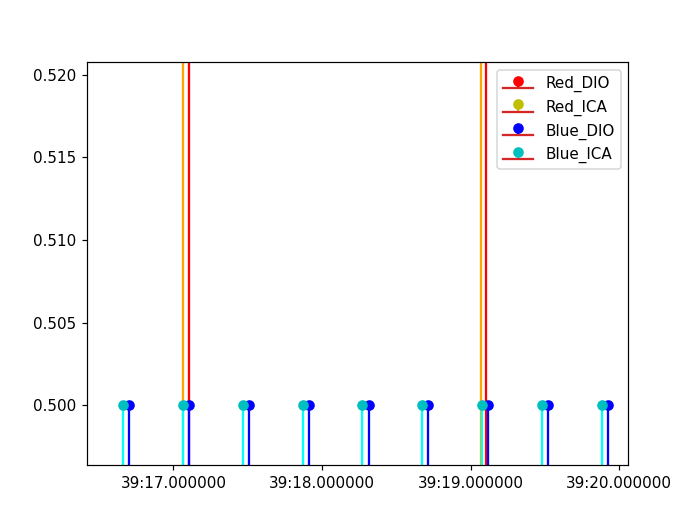

/tmp/ipykernel_779109/1125558389.py:15: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  h1 = ax.stem(dio_com_red["Center_of_mass"], dio_com_red["Amp"],'red',markerfmt='ro') #markerfmt=' '
/tmp/ipykernel_779109/1125558389.py:16: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  h2 = ax.stem(ica_com_red["Center_of_mass"], ica_com_red["Amp"],'orange',markerfmt='yo')
/tmp/ipykernel_779109/1125558389.py:18: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  h3 = ax.stem(dio_com_blue["Center_of_mass"], dio_com_blue["Amp"],'blue',markerfmt='bo')
/tmp/ipykernel_779109/1125558389.py:19: MatplotlibDeprecationWarning: Passin

In [13]:
visualise_ica_dio_coms(dio_com_red,ica_com_red,dio_com_blue,ica_com_blue)

trimmed dio len: (1944,), before trim: (1947,) 
trimmed ica front len: (1948,), before trim: (1949,) 
trimmed ica len: (1944,), before trim: (1949,) 
Red: Trimmed dio - Trimmed ICA difference is:  [0.01209688 0.01598024 0.01707292 ... 0.03914571 0.03538513 0.0383203 ]


<IPython.core.display.Javascript object>


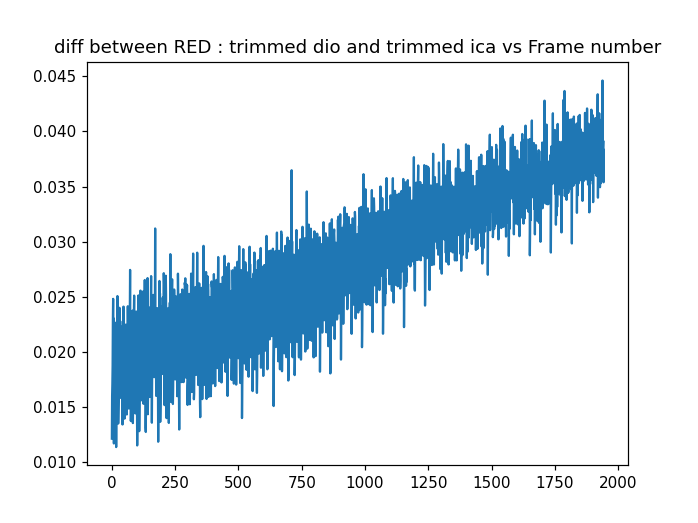

trimmed dio len: (9682,), before trim: (9688,) 
trimmed ica front len: (9701,), before trim: (9707,) 
trimmed ica len: (9682,), before trim: (9707,) 
Trimmed dio - Trimmed ICA difference is:  [0.01388741 0.01923203 0.01694632 ... 0.04212642 0.0438714  0.03979015]


<IPython.core.display.Javascript object>


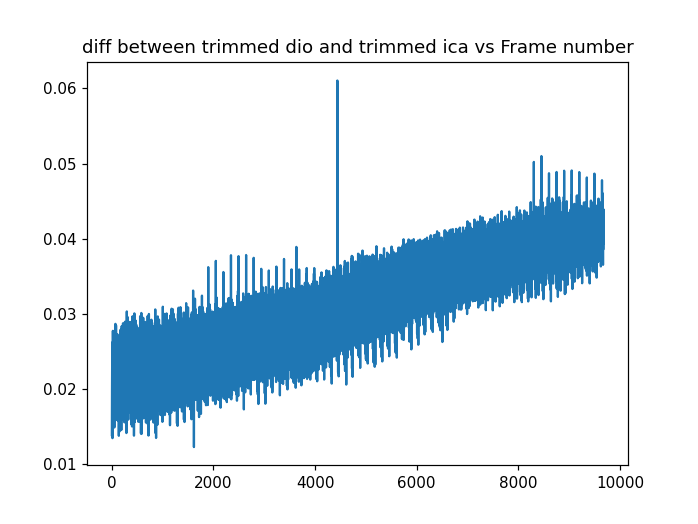

Red ICA total timestamps: [1.60492166e+09 1.60492166e+09 1.60492166e+09 ... 1.60492557e+09
 1.60492557e+09 1.60492557e+09]
Offset for final correction(s) is:  0.021303176879882812


<IPython.core.display.Javascript object>


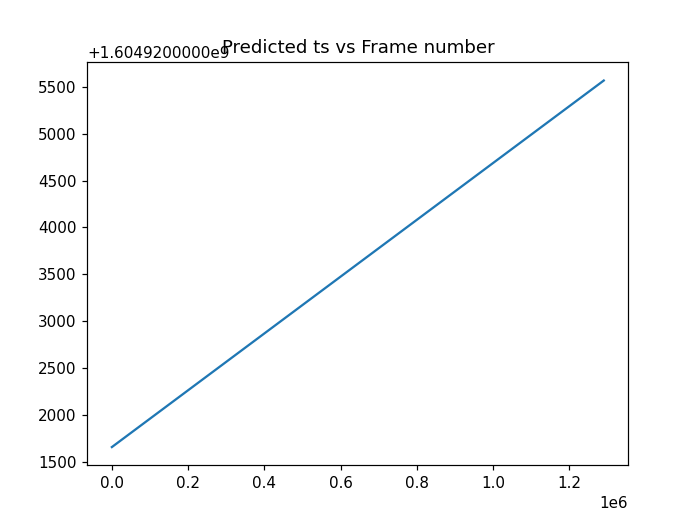

<IPython.core.display.Javascript object>


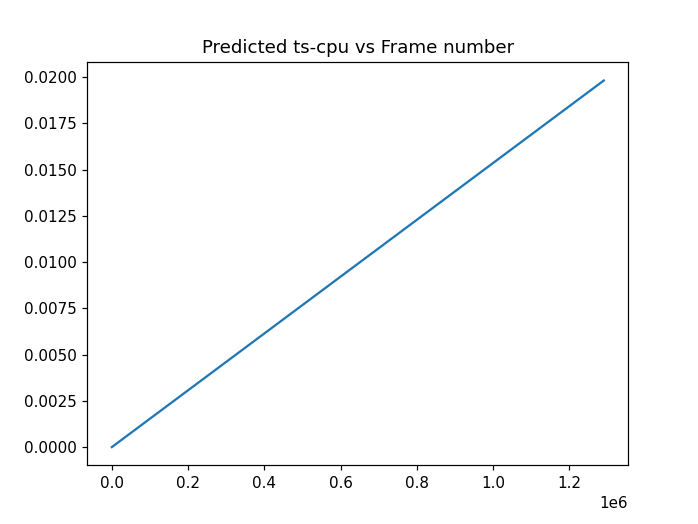

<IPython.core.display.Javascript object>


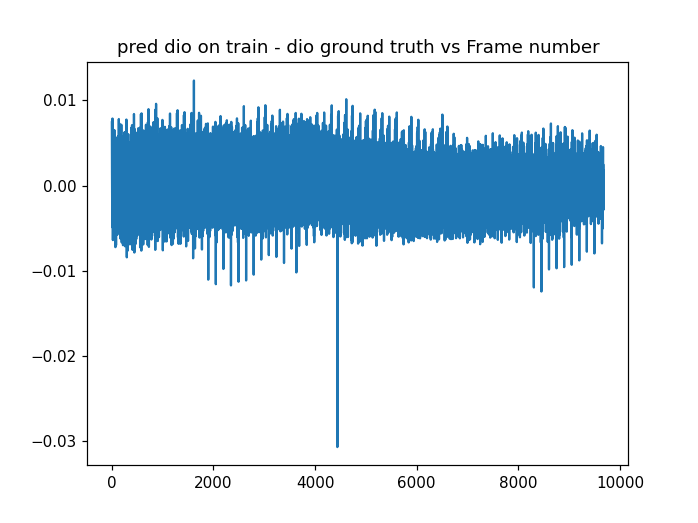

<IPython.core.display.Javascript object>


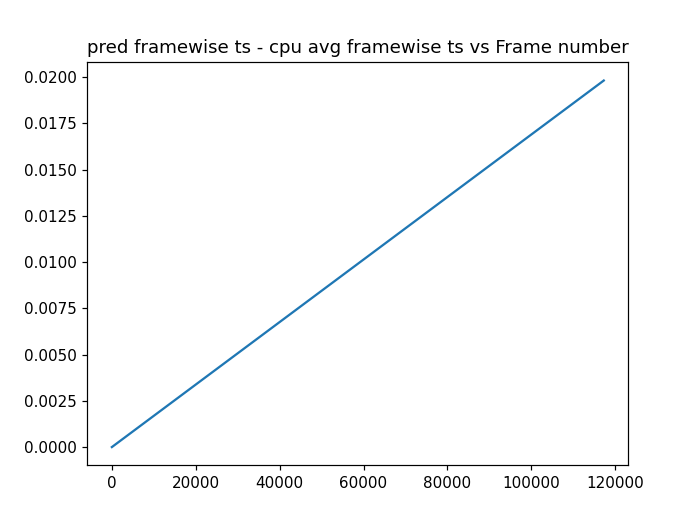

Predicted DIO from regressor: [1.60492166e+09 1.60492166e+09 1.60492166e+09 ... 1.60492557e+09
 1.60492557e+09 1.60492557e+09]
Min diff in seconds between final corrected vs cpu corrected: 0.0
Max diff in seconds between final corrected vs cpu corrected:: 0.019818782806396484


In [14]:
ts_ica_red = pd.to_datetime(ica_com_red['Center_of_mass']).astype(int)/ 10**9
ts_dio_red = pd.to_datetime(dio_com_red['Center_of_mass']).astype(int)/ 10**9

ts_dio_blue = pd.to_datetime(dio_com_blue['Center_of_mass']).astype(int)/ 10**9
ts_ica_blue = pd.to_datetime(ica_com_blue['Center_of_mass']).astype(int)/ 10**9


ica_train_red, dio_train_red, ica_train_blue, dio_train_blue = trim_ts_before_first_overlap(ts_ica_red, 
                                                                                            ts_dio_red, 
                                                                                            ts_ica_blue, 
                                                                                            ts_dio_blue)
red_ica_corrected_s = pd.to_datetime(red_ica_total['key']).astype(int)/ 10**9
blue_ica_corrected_s = pd.to_datetime(blue_ica_total['key']).astype(int)/ 10**9
print("Red ICA total timestamps:",red_ica_corrected_s.to_numpy())
# Train on red and test on blue
# train_set_size = int(0.5 * len(ica_train_red))
pred_dio_blue,pred_dio_red,pred_framewise_ts = pred_dio_ts_from_ica_ts_and_verify(ica_train_blue,dio_train_blue,
                                                                blue_ica_corrected_s.to_numpy(),
                                                                red_ica_corrected_s.to_numpy(),
                                                                avg_ts_per_frame,
                                                                vis_on=True)
print("Predicted DIO from regressor:",pred_dio_blue)
# print(dio_train_red[train_set_size:], pred_dio_red)
diff = pred_dio_blue - blue_ica_corrected_s.to_numpy()
print("Min diff in seconds between final corrected vs cpu corrected:", np.min(diff))
print("Max diff in seconds between final corrected vs cpu corrected::", np.max(diff))

In [15]:
# Save the corrected average framewise ts to csv file
pred_ts_df = pd.DataFrame(pred_framewise_ts,columns=['Corrected Time Stamp'])
pred_ts_df.to_csv(out_path + "stitched_framewise_ts.csv",index_label='Frame Number')
# blue_ica_corrected_s.to_csv(args.output_path + "blue_corrected_ts.csv")

gpu ts:699142308496.0, cpu_ts: 1604918058.460756, reg_ts: 1604918058.4617968, offset: 0.0009696433544158935, corrected ts:1604918058.460827


<IPython.core.display.Javascript object>


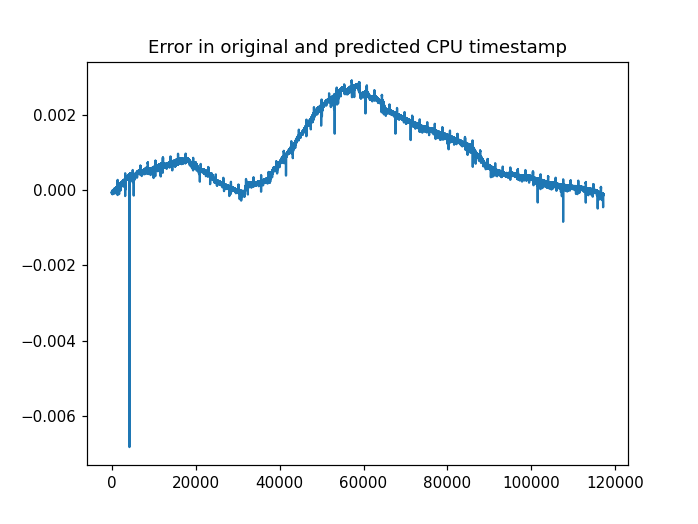

<IPython.core.display.Javascript object>


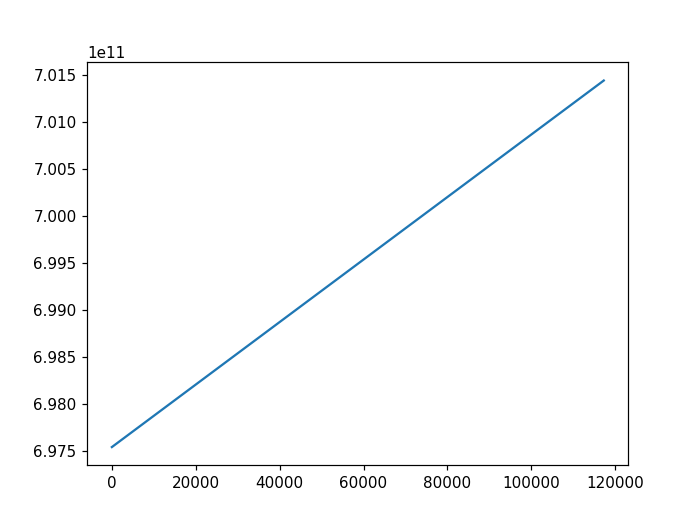

gpu ts:699145901820.0, cpu_ts: 1604918058.461328, reg_ts: 1604918058.4623597, offset: 0.0009796512126922607, corrected ts:1604918058.46138


<IPython.core.display.Javascript object>


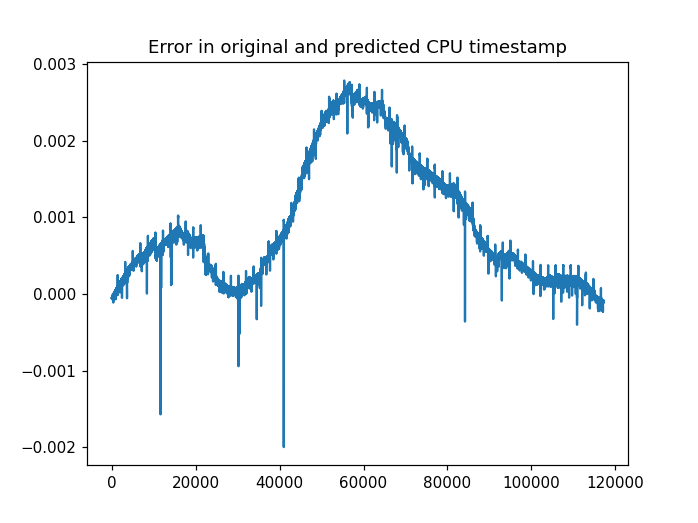

<IPython.core.display.Javascript object>


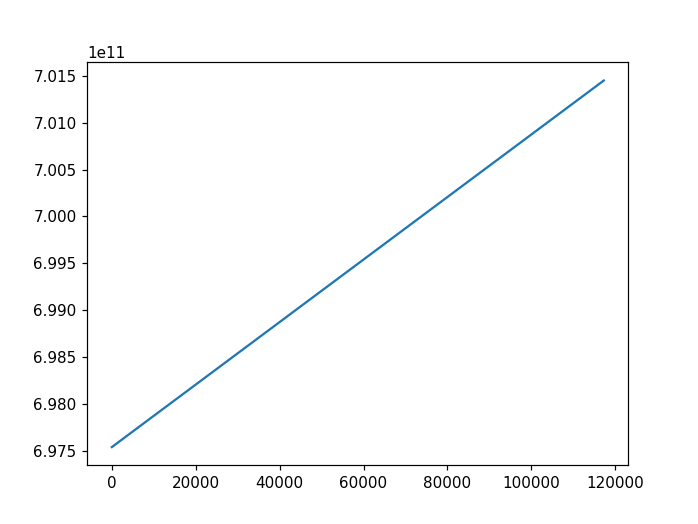

gpu ts:699141161179.0, cpu_ts: 1604918058.478118, reg_ts: 1604918058.4791903, offset: 0.0010097856521606445, corrected ts:1604918058.4781806


<IPython.core.display.Javascript object>


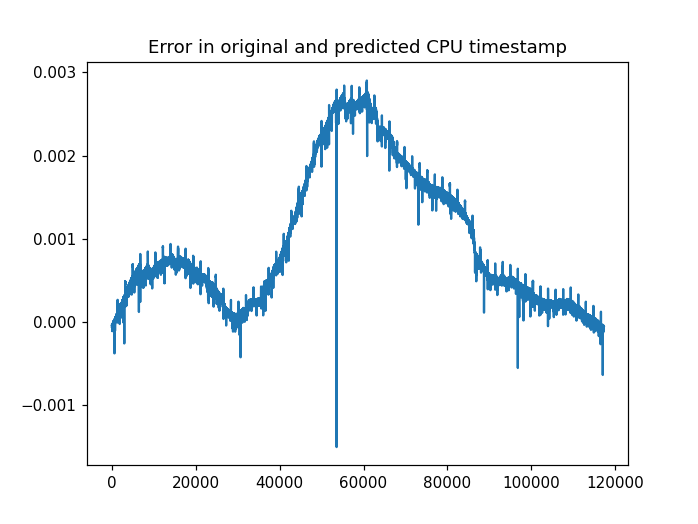

<IPython.core.display.Javascript object>


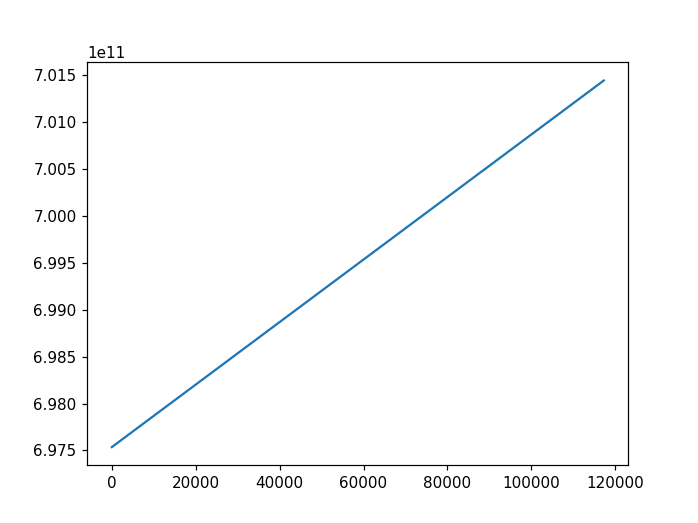

gpu ts:699148008480.0, cpu_ts: 1604918058.471754, reg_ts: 1604918058.4728491, offset: 0.0010380709171295165, corrected ts:1604918058.471811


<IPython.core.display.Javascript object>


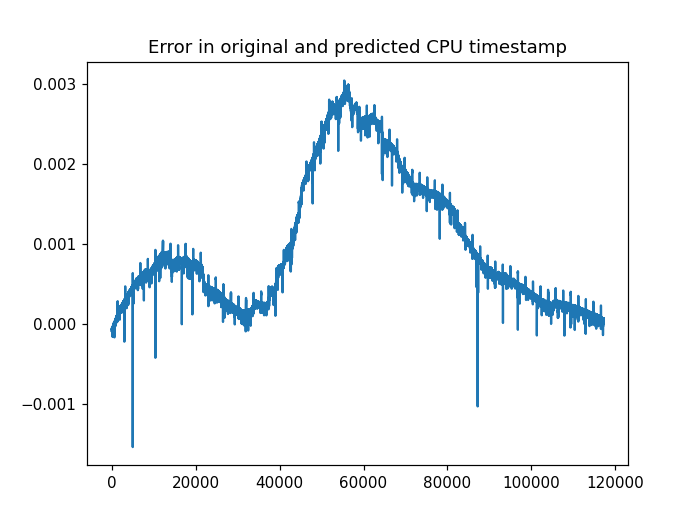

<IPython.core.display.Javascript object>


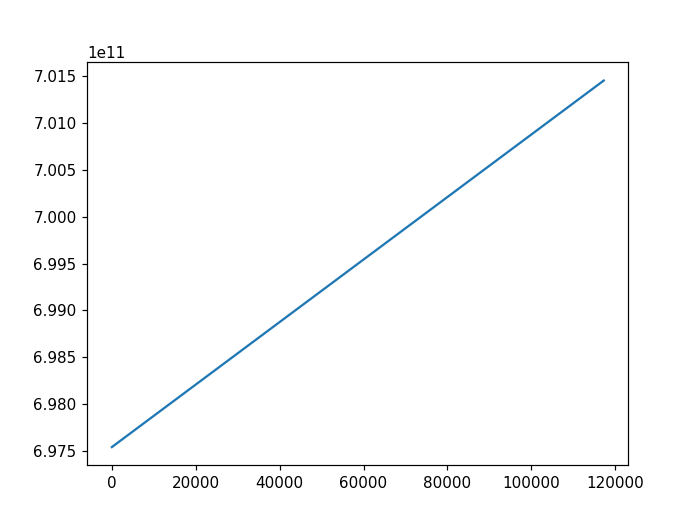

gpu ts:699145245986.0, cpu_ts: 1604918058.468963, reg_ts: 1604918058.4700136, offset: 0.0009748663902282715, corrected ts:1604918058.4690387


<IPython.core.display.Javascript object>


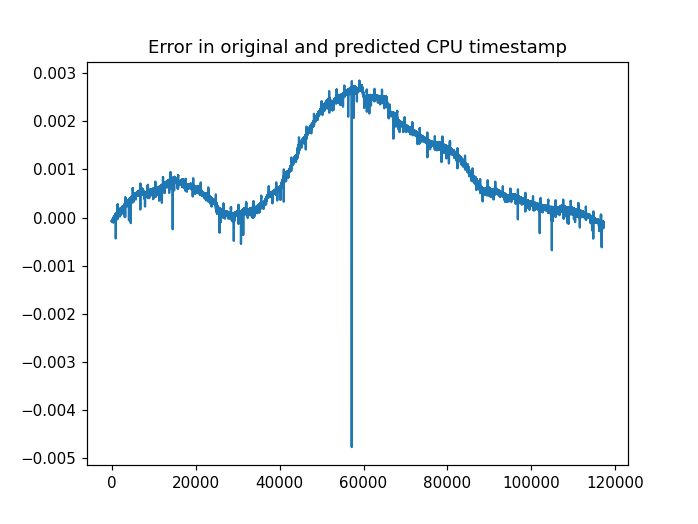

<IPython.core.display.Javascript object>


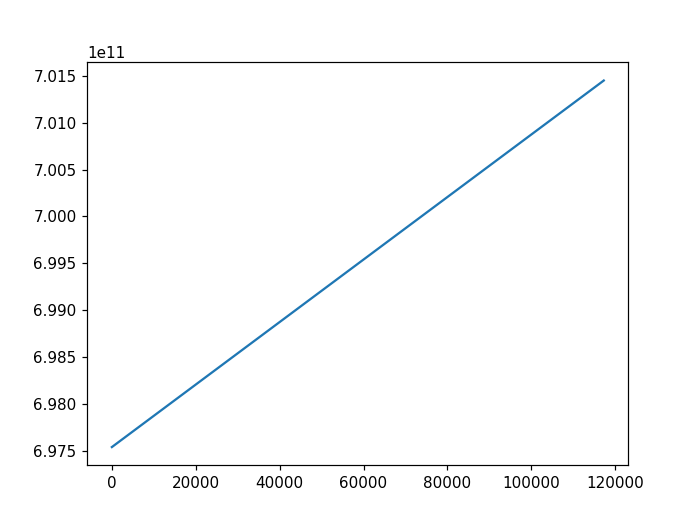

gpu ts:699146504320.0, cpu_ts: 1604918058.465673, reg_ts: 1604918058.4667776, offset: 0.0010343477725982665, corrected ts:1604918058.4657433


<IPython.core.display.Javascript object>


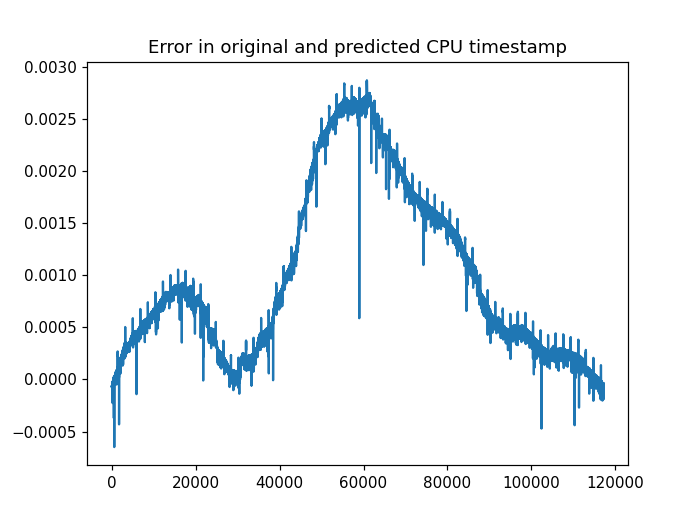

<IPython.core.display.Javascript object>


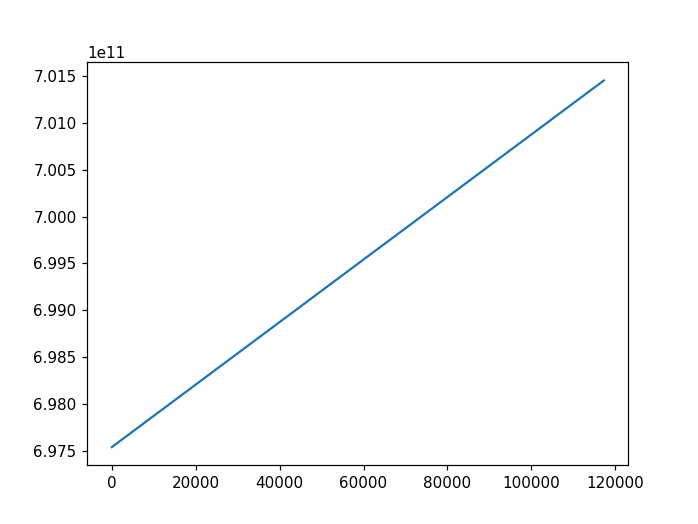

gpu ts:699147633606.0, cpu_ts: 1604918058.458613, reg_ts: 1604918058.4597268, offset: 0.0010247092247009277, corrected ts:1604918058.458702


<IPython.core.display.Javascript object>


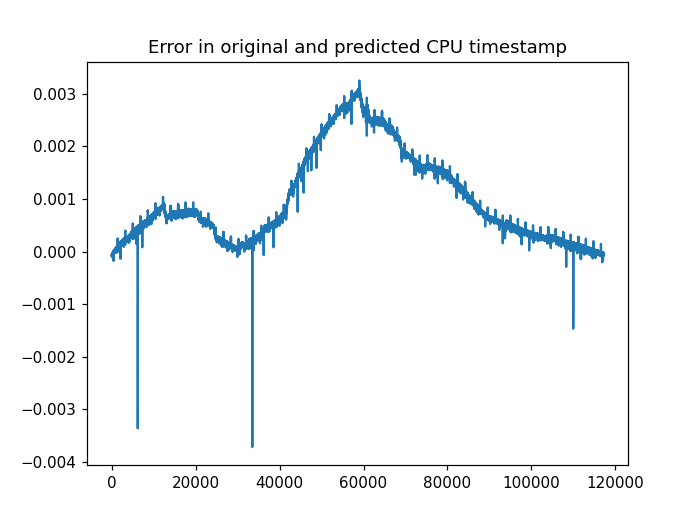

/tmp/ipykernel_779109/3871332562.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


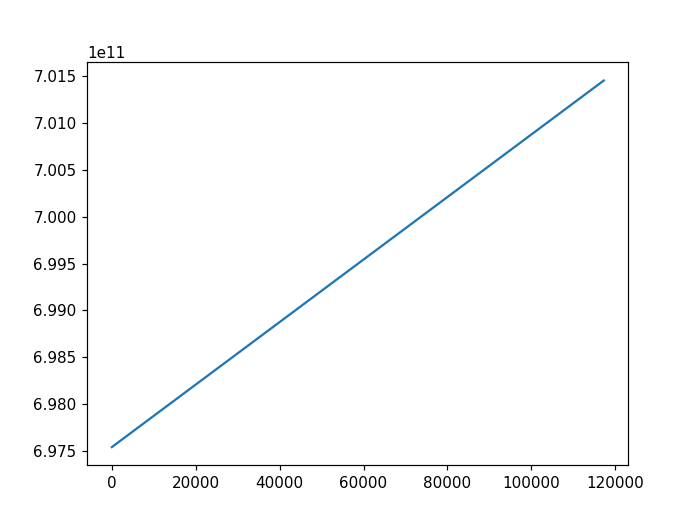

gpu ts:699147066237.0, cpu_ts: 1604918058.456079, reg_ts: 1604918058.4571333, offset: 0.0010104844570159913, corrected ts:1604918058.4561229


<IPython.core.display.Javascript object>


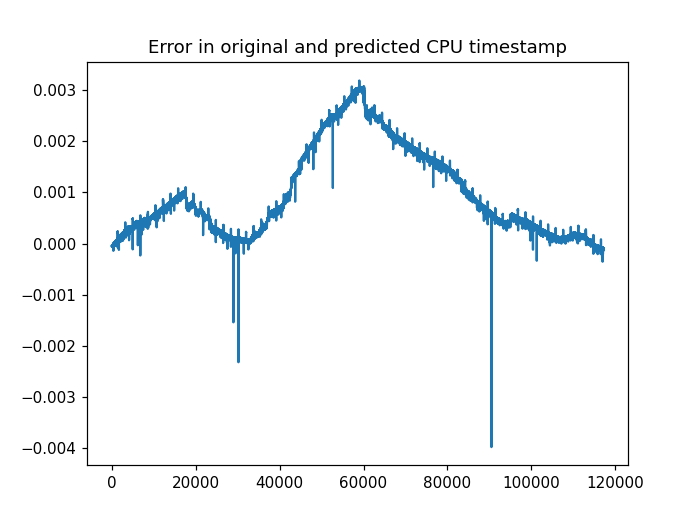

<IPython.core.display.Javascript object>


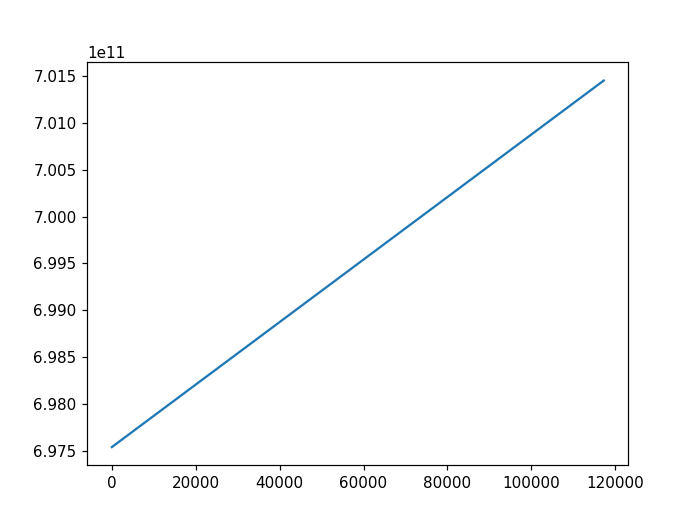

gpu ts:699142248609.0, cpu_ts: 1604918058.463143, reg_ts: 1604918058.464142, offset: 0.0009391484260559082, corrected ts:1604918058.463203


<IPython.core.display.Javascript object>


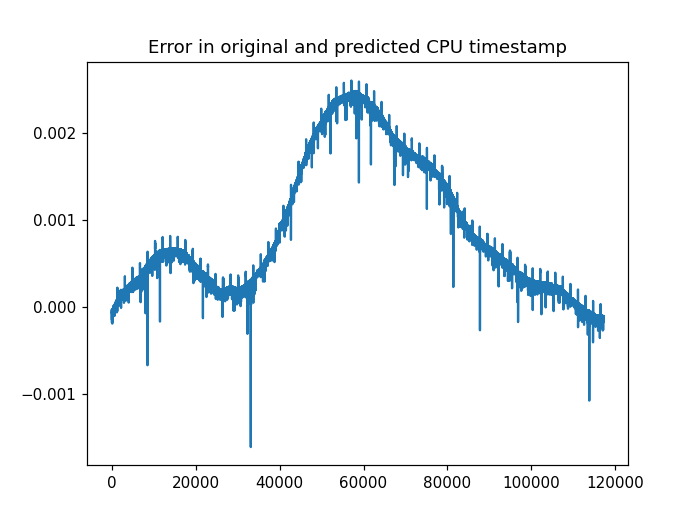

<IPython.core.display.Javascript object>


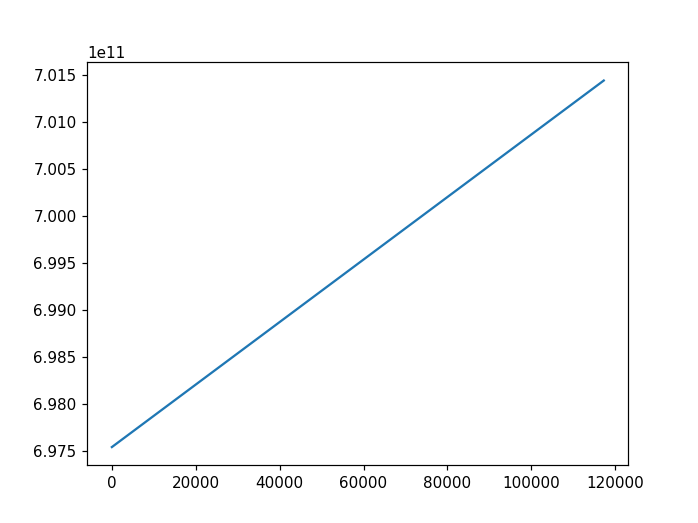

gpu ts:699145999581.0, cpu_ts: 1604918058.473863, reg_ts: 1604918058.4749486, offset: 0.0010275585651397705, corrected ts:1604918058.473921


<IPython.core.display.Javascript object>


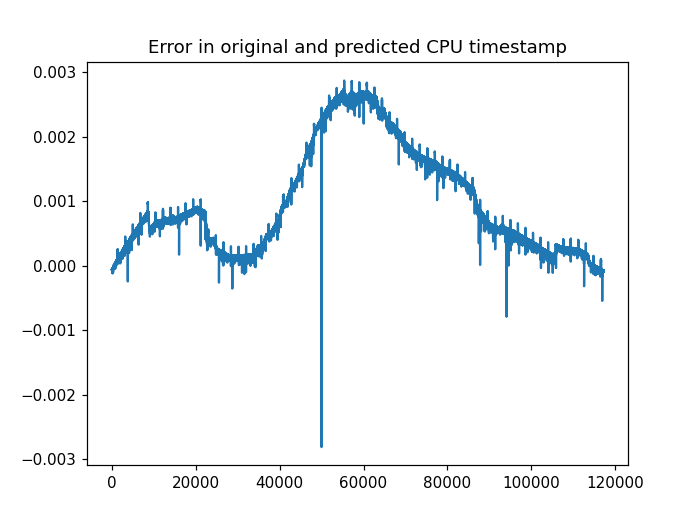

<IPython.core.display.Javascript object>


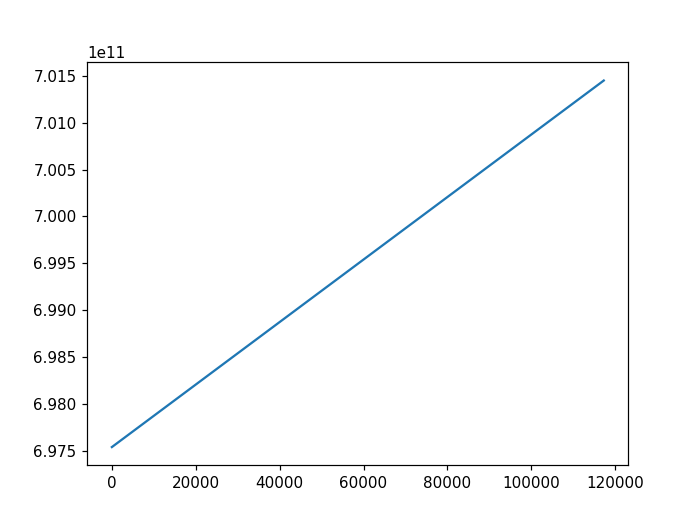

gpu ts:699147840290.0, cpu_ts: 1604918058.47333, reg_ts: 1604918058.4744265, offset: 0.0010394911766052246, corrected ts:1604918058.473387


<IPython.core.display.Javascript object>


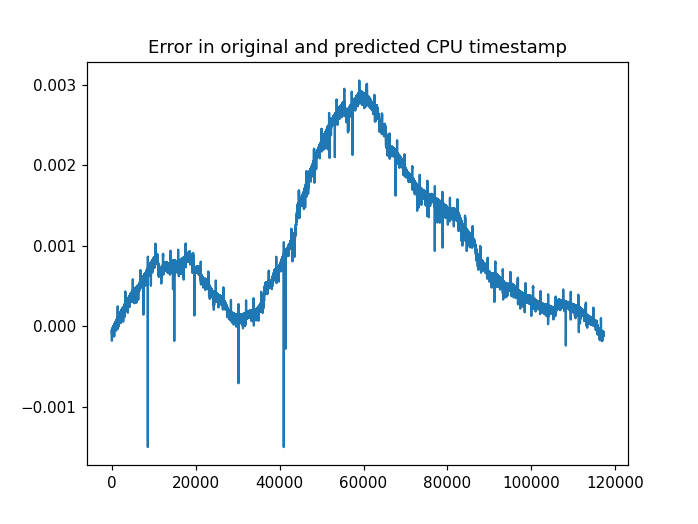

<IPython.core.display.Javascript object>


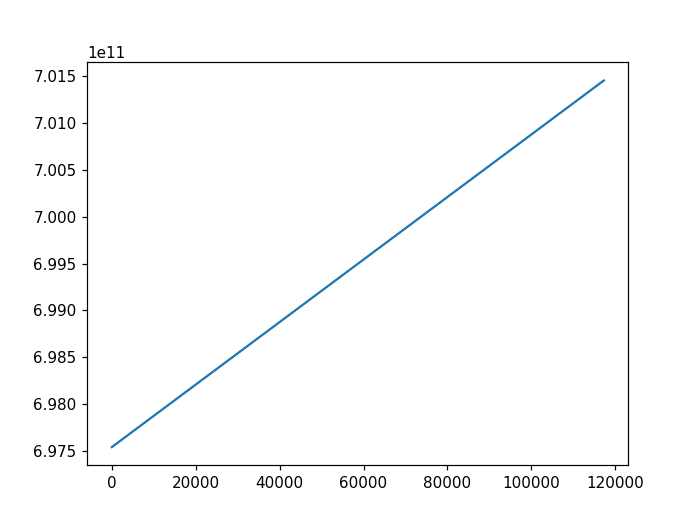

In [16]:
# To visualise the gpu and cpu timestamps difference
# Check this function definition above
vis_gpu_cpu_ts()